## Graph Classification

In [1]:
#  dataset from https://snap.stanford.edu/data/deezer_ego_nets.html
import json
import random

import numpy as np
import pandas as pd

import torch
from torch.nn import Linear
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.datasets import TUDataset
from torch_geometric.utils import to_networkx

import networkx as nx

import matplotlib.pyplot as plt

/Users/tabaneslami/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [3]:
def display_graph(gr):
    nx_gr = to_networkx(gr)
    nx.draw(nx_gr, node_size=1, arrows=False)

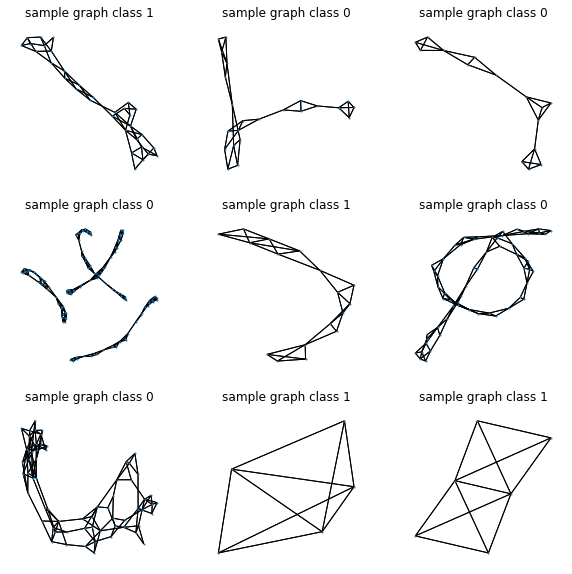

In [4]:
graph_data = TUDataset(root='data/TUdataset', name='PROTEINS')
graph_data.shuffle()
num_features = graph_data[0].x.shape[-1]
plt.figure(figsize=(10,10))
fig, axis = plt.subplots(3,3, num=1)
for i in range(9):
    idx_graph = random.randint(1,len(graph_data))
    row, col = int(i/3), int(i%3)
    plt.sca(axis[row, col])
    display_graph(graph_data[idx_graph])
    axis[row, col].set_title(f'sample graph class {graph_data[idx_graph].y.item()}')


In [5]:
train_data = graph_data[:1000]
test_data = graph_data[1000:]

In [6]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64)

In [7]:
class graph_classifier(torch.nn.Module):
    def __init__(self, num_features, hidden_channel_1, hidden_channnel2, num_class):
        super(graph_classifier, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channel_1)
        self.conv2 = GCNConv(hidden_channel_1, hidden_channnel2)
        self.linear = Linear(hidden_channnel2, num_class)
    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = global_mean_pool(x, batch)
        x = self.linear(x)
        return x

In [8]:
def compute_accuracy(model, test_loader):
    model.eval()
    correct = 0
    for data in test_loader:
        output = torch.argmax(model(data.x, data.edge_index, data.batch), axis=1)
        target = data.y
        correct += torch.sum(output==target)/len(target)
    accuracy = correct/len(test_loader)
    model.train()
    return accuracy

In [10]:
model = graph_classifier(3, 20, 20, 2)
model.train()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()
for epoch in range(101):
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        target = data.y
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()
    if epoch%10==0:
        acc = compute_accuracy(model, train_loader)
        print(f'accuracy at epoch {epoch}: {acc}')


accuracy at epoch 0: 0.6591796875
accuracy at epoch 10: 0.660937488079071
accuracy at epoch 20: 0.6615234613418579
accuracy at epoch 30: 0.69140625
accuracy at epoch 40: 0.717968761920929
accuracy at epoch 50: 0.720507800579071
accuracy at epoch 60: 0.7236328125
accuracy at epoch 70: 0.7232421636581421
accuracy at epoch 80: 0.726367175579071
accuracy at epoch 90: 0.7212890386581421
accuracy at epoch 100: 0.726367175579071
